In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(230)
print(tf.__version__)

from matplotlib import pyplot as plt

import sys
sys.path.append('..')

/Documents/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.12.0


In [3]:
from configs.seq_fd_gru import hparams
hparams = hparams()
print(hparams)

[('batch_size', 800), ('datagen', 'prodn'), ('in_seq_len', 168), ('input_channels', 1), ('input_dim', 5), ('lambd', 1e-06), ('learning_rate', 0.001), ('logs_path', '/tmp/tensorflow_logs'), ('lr_decay', 0.99), ('neurons_unit', 32), ('norm_epsilon', 1e-12), ('num_layers', 1), ('out_seq_len', 24), ('output_channels', 1), ('output_dim', 1), ('test_split', 0.1), ('train_split', 0.8), ('val_split', 0.1)]


In [127]:
hparams.in_seq_len = 513
hparams.out_seq_len = 1
hparams.input_dim = 1
hparams.lambd=0
hparams.lr_decay=0.99
hparams.learning_rate=10**-2.5
hparams.batch_size=100

params = {
    "filter_width": 2,
    "sample_rate": 16000,
    "dilations": [1, 2, 4, 8, 16, 32, 64],
    "residual_channels": 16,
    "dilation_channels": 16,
    "quantization_channels": 100,
    "skip_channels": 32,
    "use_biases": True,
    "scalar_input": False,
    "initial_filter_width": 2
}

In [128]:
from data_loader.biogas import *
get_fields = 'AT305'
dataset, dataset_val, dataset_test = load_data(hparams, mode=get_fields, normalise='local_max')
inp, target, mask, x_max = next(iter(dataset))

In [ ]:
class WaveNet(tf.keras.Model):
    """
    https://github.com/ibab/tensorflow-wavenet
    """
    def __init__(self, params):
        super(WaveNet, self).__init__()
        
        self.params = params
        self.outputs = []
        self.stack = []
        self.receptive_field = params['initial_filter_width'] + \
                               (params['filter_width'] - 1) * sum(params['dilations'])
        
        # Pre-process the input with a regular convolution
        self.pre_process_layer = self._create_causal_conv('pre-process', params, 1, 'linear', True)
        
        # Create dilation layers
        current_layer = self.pre_process_layer
        with tf.name_scope('dilated_stack'):
            for layer_index, dilation in enumerate(params['dilations']):
                with tf.name_scope('layer{}'.format(layer_index)):
                    dilation_layer = self._create_dilation_layer(layer_index, dilation, params)
                    self.stack.append(dilation_layer)
                    
        # Post-process the outputs
        with tf.name_scope('post_process'):
            with tf.name_scope('conv_1'):
                self.post_process1 = tf.keras.layers.Conv1D(params['skip_channels'], 1,
                                        padding='same', use_bias=params['use_biases'],
                                        activation='relu')
            with tf.name_scope('conv_2'):
                self.post_process2 = tf.keras.layers.Conv1D(params['quantization_channels'], 1,
                                        padding='same', use_bias=params['use_biases'],
                                        activation='linear')

                    
    def _create_causal_conv(self, name, params, dilation, activation, is_initial_layer):
        with tf.name_scope(name):
            filter_width = params['initial_filter_width'] if is_initial_layer else params['filter_width']

            return tf.keras.layers.Conv1D(params['residual_channels'], filter_width,
                                            padding='valid', use_bias=params['use_biases'],
                                            dilation_rate = dilation, activation=activation)
    
    def _create_dilation_layer(self, layer_index, dilation, params):
        
        block = {}

        # Dilated convolutions
        block['filter'] = self._create_causal_conv('filter', params, dilation, 'sigmoid', False)
        block['gate']   = self._create_causal_conv('gate', params, dilation, 'tanh',    False)

        # 1x1 conv for residual and skip outputs
        with tf.name_scope('dense'):
            block['dense']  = tf.keras.layers.Conv1D(params['dilation_channels'], 1, activation='linear',
                                        padding='same', use_bias=params['use_biases'])
        with tf.name_scope('skip'):
            block['skip']  = tf.keras.layers.Conv1D(params['skip_channels'], 1, activation='relu',
                                        padding='same', use_bias=params['use_biases'])
        
        return block
    
    def call(self, inp, mask):
        self.skip_connections = []
        output_width = tf.shape(inp)[1] - self.receptive_field + 1
        
        x = self.pre_process_layer(inp)

        for layer_index, dilation in enumerate(self.params['dilations']):
            block = self.stack[layer_index]

            # Dilation connection
            x_conv = block['filter'](x) * block['gate'](x)
            
            # Skip connection
            skip_cut = tf.shape(x_conv)[1] - output_width
            x_skip = tf.slice(x_conv, [0, skip_cut, 0], [-1, -1, -1])
            x_skip = block['skip'](x_skip)
            self.skip_connections.append(x_skip)

            # Dense residual connection
            x_dens = block['dense'](x_conv)
            input_cut = tf.shape(x)[1] - tf.shape(x_dens)[1]
            x = x_dens + tf.slice(x, [0, input_cut, 0], [-1, -1, -1])

        total = sum(self.skip_connections)
        total = self.post_process1(total)
        total = self.post_process2(total)

        return total

In [120]:
class WaveNet(tf.keras.Model):
    '''
    https://github.com/NVIDIA/nv-wavenet/blob/master/pytorch/wavenet.py
    '''
    def __init__(self, params):
        super(WaveNet, self).__init__()

        self.num_layers = len(params['dilations'])
        self.max_dilation = max(params['dilations'])
        self.residual_channels = params['residual_channels'] 
        self.skip_channels = params['skip_channels'] 
        self.out_channels = params['quantization_channels']
        
        self.dilate_layers = []
        self.res_layers = []
        self.skip_layers = []
        
        self.embed = tf.keras.layers.Embedding(self.out_channels, self.residual_channels)
        self.conv_out = tf.keras.layers.Conv1D(self.out_channels , 1, use_bias=False, activation='relu')
        self.conv_end = tf.keras.layers.Conv1D(self.out_channels, 1, use_bias=False)

        loop_factor = np.floor(np.log2(self.max_dilation)) + 1
        for i in range(self.num_layers):
            dilation = int(2 ** (i % loop_factor))
            
            # Kernel size is 2 in nv-wavenet
            in_layer = tf.keras.layers.Conv1D(2 * params['residual_channels'], kernel_size=2, padding='causal',
                                              dilation_rate=dilation, use_bias=params['use_biases'])
            self.dilate_layers.append(in_layer)

            # last one is not necessary
            if i < self.num_layers - 1:
                res_layer = tf.keras.layers.Conv1D(params['residual_channels'], 1, use_bias=params['use_biases'])
                self.res_layers.append(res_layer)

            skip_layer = tf.keras.layers.Conv1D(params['skip_channels'], 1, use_bias=params['use_biases'])

            self.skip_layers.append(skip_layer)

    def call(self, inp, mask):
        inp = self.embed(tf.cast(500 * (tf.squeeze(inp) - 0.85), tf.int16))
       
        for i in range(self.num_layers):
            in_act = self.dilate_layers[i](inp)
            t_act = tf.tanh(in_act[:, :, :self.residual_channels])
            s_act = tf.sigmoid(in_act[:, :, self.residual_channels:])
            acts = t_act * s_act
            if i < len(self.res_layers):
                res_acts = self.res_layers[i](acts)
            inp = res_acts + inp

            if i == 0:
                output = self.skip_layers[i](acts)
            else:
                output = self.skip_layers[i](acts) + output

        output = tf.nn.relu(output)
        output = self.conv_out(output)
        output = tf.nn.relu(output)
        output = self.conv_end(output)
        
        # Remove last probability and replace first value with 0's because we don't know

        last = output[:, :, -1:]
        output = output[:, :, :-1]
        first = last * 0.0
        output = tf.concat((first, output), 2)

        return output

In [119]:
class WaveNet(tf.keras.Model):
    '''
    https://github.com/NVIDIA/nv-wavenet/blob/master/pytorch/wavenet.py
    Teacher forcing model
    '''
    def __init__(self, params):
        super(WaveNet, self).__init__()

        self.num_layers = len(params['dilations'])
        self.max_dilation = max(params['dilations'])
        self.residual_channels = params['residual_channels'] 
        self.skip_channels = params['skip_channels'] 
        self.out_channels = params['quantization_channels']
        
        self.dilate_layers = []
        self.res_layers = []
        self.skip_layers = []
        
        self.embed = tf.keras.layers.Embedding(self.out_channels, self.residual_channels)
        self.conv_out = tf.keras.layers.Conv1D(params['dilation_channels'] , 1, use_bias=False, activation='relu')
        self.conv_end = tf.keras.layers.Conv1D(self.out_channels, 1, use_bias=False)

        loop_factor = np.floor(np.log2(self.max_dilation)) + 1
        for i in range(self.num_layers):
            dilation = int(2 ** (i % loop_factor))
            
            # Kernel size is 2 in nv-wavenet
            in_layer = tf.keras.layers.Conv1D(2 * params['residual_channels'], kernel_size=2, padding='causal',
                                              dilation_rate=dilation, use_bias=params['use_biases'])
            self.dilate_layers.append(in_layer)

            # last one is not necessary
            if i < self.num_layers - 1:
                res_layer = tf.keras.layers.Conv1D(params['residual_channels'], 1, use_bias=params['use_biases'])
                self.res_layers.append(res_layer)

            skip_layer = tf.keras.layers.Conv1D(params['skip_channels'], 1, use_bias=params['use_biases'])

            self.skip_layers.append(skip_layer)

    def call(self, inp, mask):
        embedded_inp = self.embed(tf.cast(500 * (tf.squeeze(inp) - 0.85), tf.int16))
        predictions = []

        for t in range(24):
            inp = embedded_inp[:,-129:]
            for i in range(self.num_layers):
                in_act = self.dilate_layers[i](inp[:,-129:])
                t_act = tf.tanh(in_act[:, :, :self.residual_channels])
                s_act = tf.sigmoid(in_act[:, :, self.residual_channels:])
                acts = t_act * s_act
                if i < len(self.res_layers):
                    res_acts = self.res_layers[i](acts)
                inp = res_acts + inp

                if i == 0:
                    output = self.skip_layers[i](acts)
                else:
                    output = self.skip_layers[i](acts) + output

            output = tf.nn.relu(output)
            output = self.conv_out(output)
            output = tf.nn.relu(output)
            output = self.conv_end(output)
            predictions.append(output[:,-1:])
            
            output = tf.argmax(output[:,-1:], axis=2)
            output = self.embed(output)
            embedded_inp = tf.concat([embedded_inp, output], 1)

        return tf.concat(predictions, 1)

In [121]:
model = WaveNet(params)
optimizer= tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)

In [ ]:
for epoch in range(10):
    losses = []
    for inp, target, mask, x_max in iter(dataset):
        with tf.GradientTape() as tape:
            pred = model(inp, mask)
            loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
                    labels=tf.cast(500 * (tf.concat([inp[:,1:], target], 1) - 0.85), tf.int32)[:,:,0],
                    logits=pred)

        # Update gradients
        variables = model.variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        losses.append(loss)

    print(epoch, ': ', np.dstack(losses).mean())

0 :  1.025277
1 :  0.961516
2 :  0.9282472
3 :  0.92131495
4 :  0.902347
5 :  0.8835634


In [152]:
forecast = inp[:,:129]
for _ in range(24):
    pred = model(forecast[:,-129:], mask)
    pred = 0.85 + tf.random.multinomial(pred[:,-1], 1) / 500
    #pred = 0.85 + tf.argmax(pred[:,-1], -1) / 500
    pred = tf.reshape(tf.cast(pred, tf.float32), [-1,1,1])
    forecast = tf.concat([forecast, pred], 1)

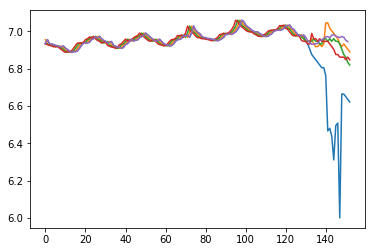

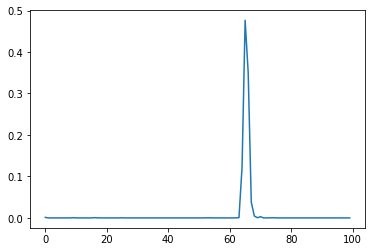

In [153]:
pred = model(inp[:,-129:], mask)
plt.plot(np.squeeze(forecast[:4]).T * np.max(x_max))
plt.plot(np.squeeze(inp[0,:152]) * np.max(x_max))
plt.show()
plt.plot(np.squeeze(tf.nn.softmax(pred[0,-1])))

In [ ]:
i = 0
forecast = np.array(inp)
pred = model(forecast[:,i:i+129], mask)
pred = 0.85 + np.argmax(pred, axis=2)[:,:,np.newaxis] / 500
forecast = np.hstack([forecast, pred])
forecast.shape

## Train Model
loss_function: Build out MSE loss function with parameter regularisation

train_model: Runs the minibatch training loop

In [ ]:
import trainers.tf_eager_trainer as trainer

# Run a training batch
tf.set_random_seed(231) # Set seed

# Initialise model and optimiser
#model_ = WaveNet(hparams.input_dim, hparams.output_dim, hparams.in_seq_len, hparams.out_seq_len,
#                hparams.neurons_unit, hparams.batch_size, dilate=False)
model = WaveNet(params)
optimizer= tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)

# Start training run
loss, accuracy, run_time, stats = trainer.train_model(model, optimizer, dataset, hparams,
                                                      epochs=25, verbose=True, dev_dataset=dataset)

# Display results
print('Loss {:.4f} Accuracy {:.4f} Time {:.4f}'.format(loss * 10000, accuracy * 10000, run_time))

plt.figure()
for name, stat in stats.items():
    if name != 'time':
        plt.plot(stat, label=name)
plt.legend()
plt.yscale('log')
plt.show()

#trainer.save_model(model, optimizer, dataset_val, hparams, 'fd_mini' + get_fields.replace(' ', '_'), stats=stats)
print(model.summary())
print(optimizer._lr)

In [ ]:
# show all sequences
# Select target sequence to show
TARGET_INDEX = 0

# Create forecast and rescale data
inp, target, mask, x_max = next(iter(dataset))
x_max = tf.expand_dims(x_max,-1)

forecast = np.array(inp)
for i in range(24):
    pred = model(forecast[:,i:i+129], mask)
    pred = 0.85 + np.argmax(pred, axis=2)[:,:,np.newaxis] / 500
    forecast = np.hstack([forecast, pred])
forecast = forecast[:,129:]
forecast *= x_max
target   *= x_max
inp      *= x_max
inp = tf.reshape(inp[:,-120:],
                 [hparams.batch_size, 5, 24])

# Plot target sequence
plt.figure(figsize=(16,12))
plt.plot(np.squeeze(forecast[TARGET_INDEX,:]), label='forecast')
plt.plot(np.squeeze(target[TARGET_INDEX:TARGET_INDEX+24,:]), label='target')
plt.plot(np.mean(inp, axis=1)[TARGET_INDEX,:], 'bo', label='5 period average')
for i in range(5):
    plt.plot(np.array(inp)[TARGET_INDEX,i], '--', label='%i periods prior' % (5-i))
plt.legend()
plt.show()

plt.figure(figsize=(16,16))
for i in range(0,800,8):
    ax = plt.subplot(10,10,i/8+1)
    ax.plot(np.squeeze(forecast[i]), label='forecast')
    ax.plot(np.squeeze(target[i:i+24]), label='target')
plt.show()

In [18]:
forecast.shape

TensorShape([Dimension(50), Dimension(24), Dimension(100)])

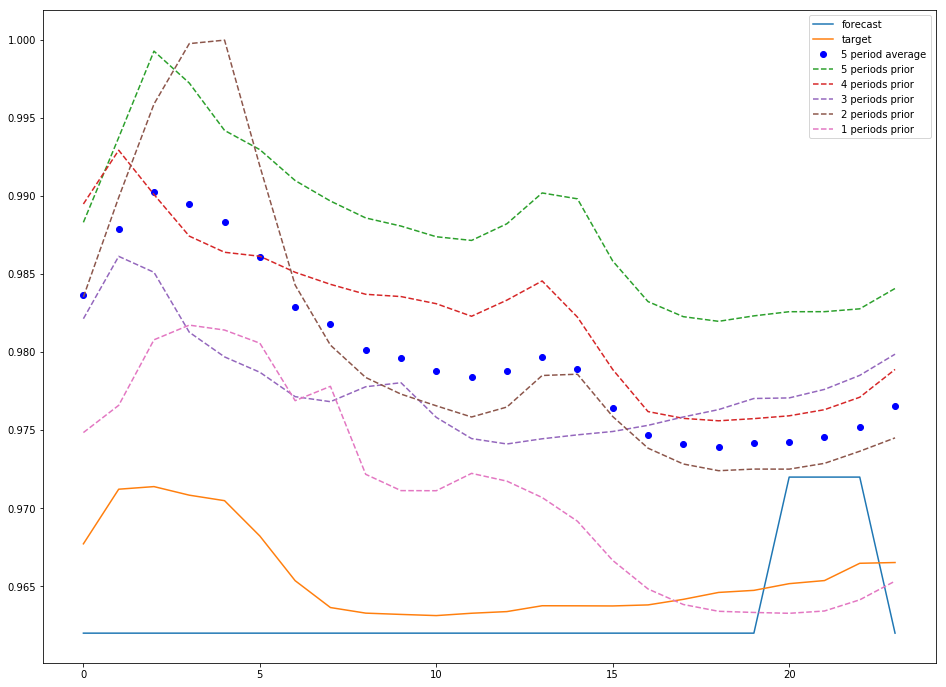

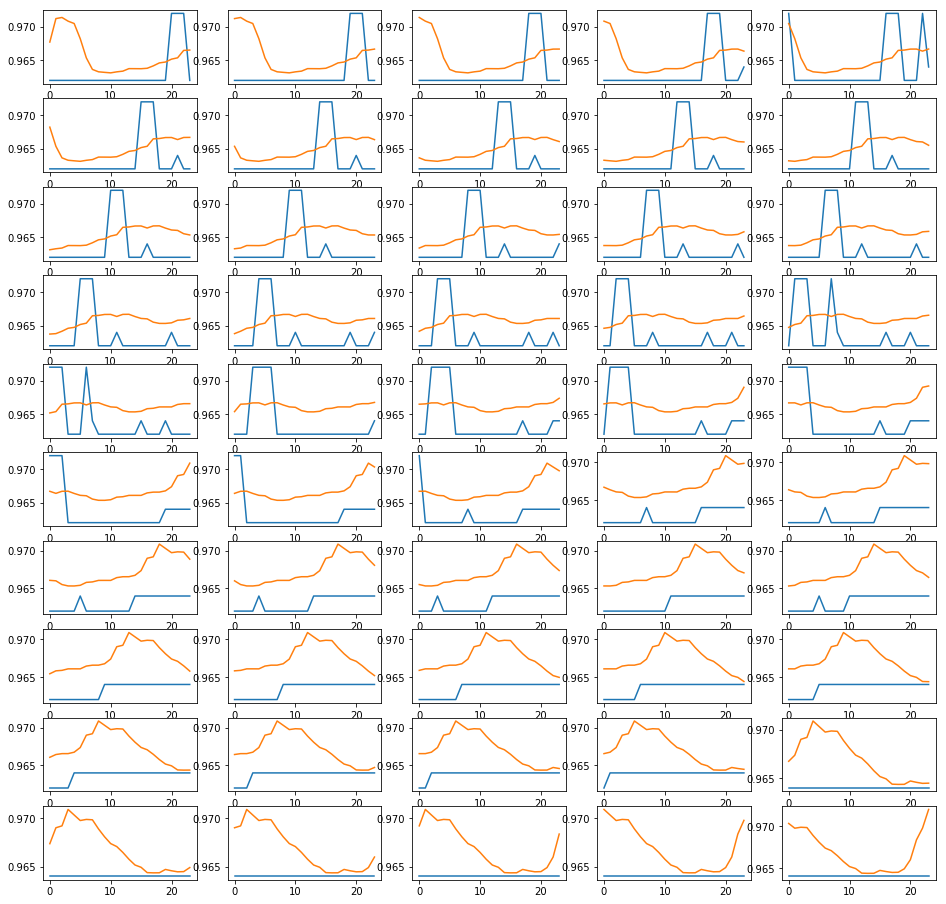

In [22]:
# show all sequences
# Select target sequence to show
TARGET_INDEX = 0

# Create forecast and rescale data
inp, target, mask, x_max = next(iter(dataset))
x_max = tf.expand_dims(x_max,-1)

forecast = model(inp, mask)
forecast = 0.85 + np.argmax(forecast, axis=2) / 500
inp = tf.reshape(inp[:,-120:],
                 [hparams.batch_size, 5, 24])

# Plot target sequence
plt.figure(figsize=(16,12))
plt.plot(np.squeeze(forecast[TARGET_INDEX,:]), label='forecast')
plt.plot(np.squeeze(target[TARGET_INDEX,:]), label='target')
plt.plot(np.mean(inp, axis=1)[TARGET_INDEX,:], 'bo', label='5 period average')
for i in range(5):
    plt.plot(np.array(inp)[TARGET_INDEX,i], '--', label='%i periods prior' % (5-i))
plt.legend()
plt.show()

plt.figure(figsize=(16,16))
for i in range(0,50,1):
    ax = plt.subplot(10,5,i+1)
    ax.plot(np.squeeze(forecast[i]), label='forecast')
    ax.plot(np.squeeze(target[i]), label='target')
plt.show()

## Test Hyperparameters

In [ ]:
np.random.seed(231)
models, stats = [], []

lr    = np.log10(hparams.learning_rate)
nodes = hparams.neurons_unit

inp, target, mask, x_max = next(iter(dataset))

#for lr in np.random.uniform(-8, -1, 10):
#for nodes in np.floor(2 ** np.arange(3,9)):
for lr in range(-8, 0, 1):
    lr /= 2

    # Run a training batch
    tf.set_random_seed(231) # Set seed

    # Initialise model and optimiser
    model_ = WaveNet(params)
    optimizer_ = tf.train.AdamOptimizer(learning_rate = 10 ** lr)

    # Start training run
    loss, accuracy, run_time, stat = \
        trainer.train_model(model_, optimizer_, dataset, hparams, epochs = 3, verbose=False)
    print('Learning Rate {:.4f} Loss {:.4f} Accuracy {:.4f} Time {:.1f}'.format(lr, loss*10000, accuracy * 10000, run_time))
    
    models.append(model_)
    stats.append(stat)

Learning Rate -3.5000 Loss 0.0254 Accuracy 0.0254 Time 32.2
Learning Rate -3.0000 Loss 0.0247 Accuracy 0.0247 Time 31.2
Learning Rate -2.5000 Loss 0.0254 Accuracy 0.0254 Time 31.5

## Test Model Accuracy

In [ ]:
model_accuracy = []

In [ ]:
for name, dataset_eval in([['Train', dataset], ['Test', dataset_test]]):
    print(name + ' Results')
    total_accuracy = []
    x_variance = x_var(hparams, mode=get_fields)

    for i, (inp, target, mask, x_max) in enumerate(dataset_eval):
        forecast = model(inp, mask)

        accuracy = tf.squeeze(forecast - target) * x_max
        accuracy = accuracy ** 2 / x_variance
        accuracy = np.mean(accuracy, axis=0)

        total_accuracy.append(accuracy)

    model_accuracy.append((hparams.in_seq_len, np.mean(total_accuracy, axis=0)))

    print('Total RSE Accuracy: %.4f' % np.mean(total_accuracy))
    print('Total MSE Accuracy: %.4f' % (np.mean(total_accuracy) * x_variance))
    plt.plot(np.mean(total_accuracy, axis=0))
plt.show()

https://github.com/ibab/tensorflow-wavenet
https://github.com/basveeling/wavenet